# Amazon Fine Food Reviews 

This is simple sentimental analysis on Amazon Fine Food Review Dataset
The project's goal is to detect whether the review is positive/negative and analyze the result of different NN architectures (loss, accuracy, ... etc) 

__Note__: Extend the sentiment analysis to multiple classes (from positive/negative to 5-score rating or positive/neutral/negative) 
          Future Work on Recommendation System using this database

### TABLE OF CONTENTS <br>
1. [__Importing Data and Preprocessing__](#01) <br> <br>
2. [__Modeling__](#2)
    - [Standard NN](#2.1)
    - [Convolutional NN with Max Pooling](#2.2)
    - [Bidirectional 2-Layer LSTM](#2.3)

In [ ]:
# Run this code if you dont have these libraries
#!pip install xgboost
#!pip install lightgbm

In [65]:
# loading libraries

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
#import pyfpgrowth

from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences 
from tensorflow.keras.layers import Embedding, Flatten, Dense, LSTM, GlobalMaxPooling1D, Bidirectional, Conv1D, Dropout, GRU 

#from sklearn.preprocessing import scale, StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, StratifiedKFold
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, recall_score, precision_score
from sklearn.feature_extraction.text import CountVectorizer          
from sklearn.feature_extraction.text import TfidfVectorizer          
#from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
print(tf.__version__)

In [ ]:
<a id='1'></a>
### 1. Import Data and Preprocessing

In [21]:
types = {'Id':'int64', 'ProductId':'str', 'UserId':'str', 
         'ProfileName':'str', 'Score': 'int', 'Text':'str'}
data = pd.read_csv('Reviews.csv', dtype = types)
df = data.copy()

In [22]:
print(df.shape)
print(df.dtypes)

(568454, 10)
Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int32
Time                       int64
Summary                   object
Text                      object
dtype: object


In [23]:
df['Score'].value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [51]:
df['Text'][mlen]

'Crazy-great condition, was doing great until my sister accidently knocked it over while I was "sunning" it outside. Also, I think using filtered tap water was a bad idea because they\'re sensitive to salts. It\'s slowly recovering.'

We took out data with score values of 3 which can be consider a neutral review and create a new column __Sentiment__ which combine all score values of 4 and 5 into value 1 (Positive Reviews)  and score values of 1 and 2 into value 0 (Negative Reviews)

In [24]:
df = df[df['Score'] != 3]
df['Sentiment'] = 0
df['Sentiment'].loc[df['Score'] > 3] = 1
print(df['Sentiment'].value_counts())

1    443777
0     82037
Name: Sentiment, dtype: int64


In [55]:
# Input the hyperparameter so we can adjust later
vocab_size  = 10000
embedding_dim = 32
max_length = 16
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'Unknown'

In [56]:
# Split Data into train and test set
train_sentences, test_sentences, train_labels, test_labels = train_test_split(df['Text'], df['Sentiment'], test_size = 0.2, random_state = 1)

# Preprocessing data 
# take in data and encode
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_sentences)
# return dict comprise of key values pair: word and its indices
word_index = tokenizer.word_index

# return a sequence of indices representing wordssentences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
test_sequences = tokenizer.texts_to_sequences(test_sentences)

# pad sequences to same length
train_padded = pad_sequences(train_sequences, maxlen = max_length, 
                               padding = padding_type, truncating = trunc_type)
test_padded = pad_sequences(test_sequences, maxlen = max_length,
                              padding = padding_type, truncating = trunc_type)

print(len(train_sentences))
print(len(test_sentences))
print(train_sentences[0])
print(train_sequences[0])
print(train_padded[0])
print(test_sequences[0])
print(test_padded[0])

420651
105163
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
[3, 76, 6, 652, 13, 3066, 4, 42, 8, 4469, 3, 117, 58, 302, 126, 13, 46, 3, 646, 184, 8, 338, 17, 62, 203, 26, 3, 316, 17, 5801, 4, 6752, 302, 126, 4, 38, 8, 5271, 236, 20, 30, 16, 3, 484, 18, 38, 8, 5271, 77, 23, 76, 5921, 4651, 302, 4, 5801, 4, 6752, 169, 76, 1683, 302, 3, 250, 66, 3082, 2664, 16, 23, 320, 100, 3483, 1732, 356, 124, 2, 356, 4, 7, 206, 38, 237, 27, 23, 118, 6, 3, 263, 139, 38, 8, 5271]
[   3   76    6  652   13 3066    4   42    8 4469    3  117   58  302
  126   13]
[10, 9, 34, 8, 14, 148, 157, 10, 580, 325, 137, 103, 59, 2406, 6065, 4, 3384, 1]
[  10    9   34    8   14  148  157   10  580  325  137  103   59 2406
 6065    4]


<a id='2'></a>
## 2. Detection Models

In [57]:
np.random.seed(0)
tf.random.set_seed(0)

<a id='2.1'></a>
### 2.1.Standard NN Model

In [58]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length = max_length), 
    Flatten(), #GlobalAveragePooling1D() is another options to go
    Dropout(0.2),
    Dense(24, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 16, 32)            320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                12312     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 332,337
Trainable params: 332,337
Non-trainable params: 0
_________________________________________________________________


In [59]:
num_epochs = 3
baseline = model.fit(train_padded, train_labels, epochs = num_epochs, 
                    validation_data = (test_padded, test_labels), verbose =2)

Train on 420651 samples, validate on 105163 samples
Epoch 1/3
420651/420651 - 74s - loss: 0.2931 - accuracy: 0.8833 - val_loss: 0.2658 - val_accuracy: 0.8955
Epoch 2/3
420651/420651 - 74s - loss: 0.2391 - accuracy: 0.9069 - val_loss: 0.2545 - val_accuracy: 0.9025
Epoch 3/3
420651/420651 - 75s - loss: 0.2128 - accuracy: 0.9179 - val_loss: 0.2571 - val_accuracy: 0.9048


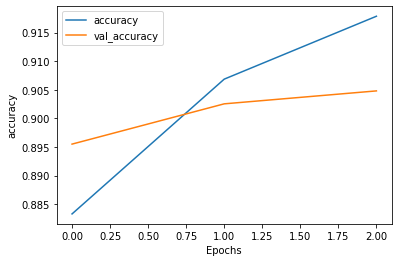

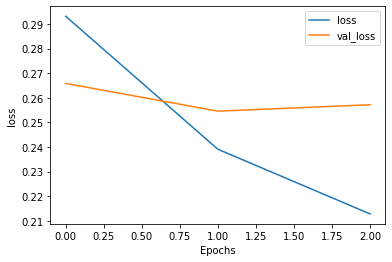

In [60]:
# Accuracy and Loss Plot
def plot_al(baseline, string):
    plt.plot(baseline.history[string])
    plt.plot(baseline.history['val_'+ string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

plot_al(baseline, "accuracy")
plot_al(baseline, 'loss')

<a id='2.2'></a>
### 2.2. 1D-Convolutional Layer NN with Max Pooling

In [61]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Dropout(0.2),
    Conv1D(64, 5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(24, activation = 'relu'),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 16, 32)            320000    
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 32)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 12, 64)            10304     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 331,889
Trainable params: 331,889
Non-trainable params: 0
________________________________________________

In [62]:
ConvMax = model.fit(train_padded, train_labels, epochs = num_epochs, 
                    validation_data = (test_padded, test_labels), verbose =2)

Train on 420651 samples, validate on 105163 samples
Epoch 1/3
420651/420651 - 96s - loss: 0.2958 - accuracy: 0.8822 - val_loss: 0.2625 - val_accuracy: 0.8966
Epoch 2/3
420651/420651 - 102s - loss: 0.2453 - accuracy: 0.9038 - val_loss: 0.2474 - val_accuracy: 0.9044
Epoch 3/3
420651/420651 - 104s - loss: 0.2215 - accuracy: 0.9140 - val_loss: 0.2390 - val_accuracy: 0.9092


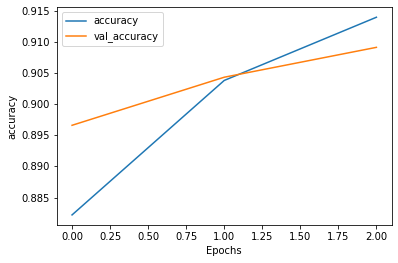

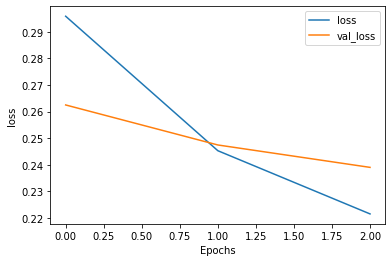

In [63]:
# Accuracy and Loss Plot
def plot_al(ConvMax, string):
    plt.plot(ConvMax.history[string])
    plt.plot(ConvMax.history['val_'+ string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

plot_al(ConvMax, "accuracy")
plot_al(ConvMax, 'loss')

<a id='2.3'></a>
## 2.3. Bidirectional 2-Layer LSTM Model

In [66]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences = True)),
    Bidirectional(LSTM(32)),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 32)            320000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 16, 128)           49664     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_6 (Dense)              (None, 24)                1560      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 25        
Total params: 412,465
Trainable params: 412,465
Non-trainable params: 0
________________________________________________

In [67]:
BiLSTM2 = model.fit(train_padded, train_labels, epochs = num_epochs, 
                    validation_data = (test_padded, test_labels), verbose =2)

Train on 420651 samples, validate on 105163 samples
Epoch 1/3
420651/420651 - 507s - loss: 0.2912 - accuracy: 0.8835 - val_loss: 0.2616 - val_accuracy: 0.8960
Epoch 2/3
420651/420651 - 506s - loss: 0.2453 - accuracy: 0.9029 - val_loss: 0.2432 - val_accuracy: 0.9035
Epoch 3/3
420651/420651 - 491s - loss: 0.2238 - accuracy: 0.9124 - val_loss: 0.2352 - val_accuracy: 0.9092


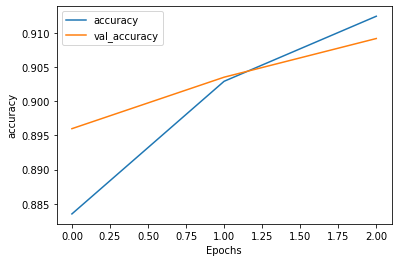

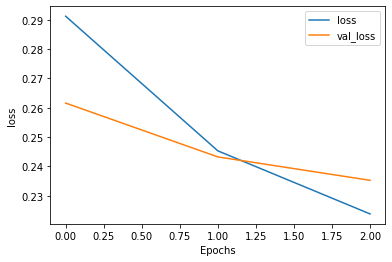

In [69]:
def plot_al(BiLSTM2, string):
    plt.plot(BiLSTM2.history[string])
    plt.plot(BiLSTM2.history['val_'+ string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+ string])
    plt.show()

plot_al(BiLSTM2, "accuracy")
plot_al(BiLSTM2, 'loss')